# Exploratory Data Analysis
In this notebook, I will perform some exploratory analysis using PCA to observe whether there is dominance of the *bx93* allele over the *sy622* allele. 

This notebook is the first to introduce the `txtome` class, which allows me to make `fc_transcriptome` objects that will enable us to do computation with a lot less code. For a thorough introduction to the `txtome` class, please view Python script in the [repository](https://github.com/WormLabCaltech/med-cafe/blob/master/src/txtome.py).

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# import own libraries
import txtome as tx
import epistasis as epi

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1  # q-value cutoff

# load the dataframe we made in the Basic Stats notebook:
quant = pd.read_csv('../input/quantifications.csv')
# initialize an fc_transcriptome object using the quant dataframe
quant = tx.fc_transcriptome(df=quant)

Dropped 0 rows with NaNs in the b column


## Data wrangling

The dataframe we have just loaded is in tidy format, meaning that each row corresponds to a single measurement. To perform PCA, we must generate a dataframe in long-format, where each column is a genotype, and each row is a particular transcript (isoform). Fortunately, the `txtome` class can do this for me instantaneously using the function `make_matrix`.

Once we have formatted the data like this, we are almost ready to perform PCA. PCA works best if the data have been normalized to have a mean of 0 and a standard deviation of 1. Even after normalization, the distribution of effects should look roughly bell curve or there could be weird effects. Let's check.

In [3]:
quant.df.head()

,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,description,transcript_biotype,strain,order,fancy,allele,genotype
0,2L52.1a,0.892540,0.984461,-0.047659,0.352794,3.894122,1.016851,0.138264,0.065421,0.075103,0.075103,WBGene00007063,2L52.1,NaN,protein_coding,PS4176,1,dpy-22(bx93)/dpy-22(sy622),bx93/sy622,bx93/sy622
1,2L52.1a,0.755861,0.936079,0.117265,0.377153,3.894122,1.016851,0.138264,0.065421,0.075103,0.075103,WBGene00007063,2L52.1,NaN,protein_coding,EW15,1,bar-1(ga80),ga80,ga80
2,2L52.1a,0.609008,0.987898,0.192910,0.377153,3.894122,1.016851,0.138264,0.065421,0.075103,0.075103,WBGene00007063,2L52.1,NaN,protein_coding,MT2124,1,let-60(n1046gf),n1046,n1046
3,2L52.1a,0.631823,1.000000,0.180717,0.377153,3.894122,1.016851,0.138264,0.065421,0.075103,0.075103,WBGene00007063,2L52.1,NaN,protein_coding,PS4187,1,dpy-22(bx93),bx93,bx93
4,2L52.1a,0.944533,0.999687,-0.026240,0.377153,3.894122,1.016851,0.138264,0.065421,0.075103,0.075103,WBGene00007063,2L52.1,NaN,protein_coding,PS4087,1,dpy-22(sy622),sy622,sy622


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


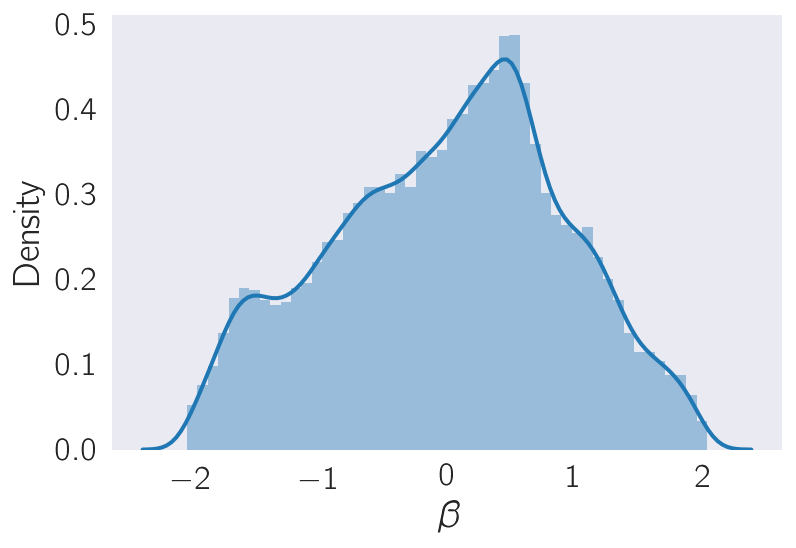

In [4]:
# generate a matrix suitable for PCA cluster
# rows are transcripts, columns are fancified genotypes
mat = quant.make_matrix(col='fancy')

# visualize distribution to make sure it's not terribly crazy
sns.distplot(mat.as_matrix().reshape(-1, 1))
_ = plt.xlabel(r'$\beta$')
_ = plt.ylabel('Density')

# PCA 

The above distribution doesn't look to crazy, so now I will perform PCA.

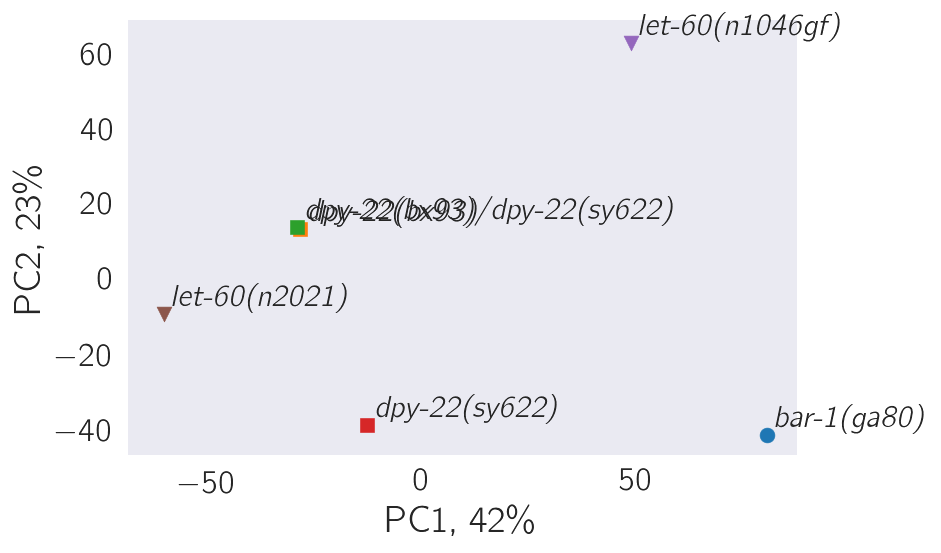

In [5]:
# initialize the object with 5 principal components
pca = PCA(5)
# fit the data and transform it to the pca coordinates
x = pca.fit_transform(mat.as_matrix().T)


# plot the data, labelling each point:
for i, cluster in enumerate(mat.columns):
    # give different marker kinds to each gene
    if 'dpy-22' in cluster:
        m = 's'
    elif 'let-60' in cluster:
        m = 'v'
    else:
        m = 'o'
    
    # make sure the labels come out in italics:
    cluster = r'\emph{' + cluster + '}'
    # plot the points
    plt.scatter(x[i, 0], x[i, 1], marker=m, label=cluster, s=55)
    # also add text to label each point
    plt.annotate(cluster, (x[i, 0]+ 2, x[i, 1]+2), fontsize=15)

# add plot labels
_ = plt.xlabel('PC1, {0:.2g}\%'.format(pca.explained_variance_ratio_[0]*100))
_ = plt.ylabel('PC2, {0:.2g}\%'.format(pca.explained_variance_ratio_[1]*100))

# save
plt.savefig('../output/pca.svg', bbox_inches='tight')

It's always good to look at the power spectrum of the eigenvalues, so let's do that as well:

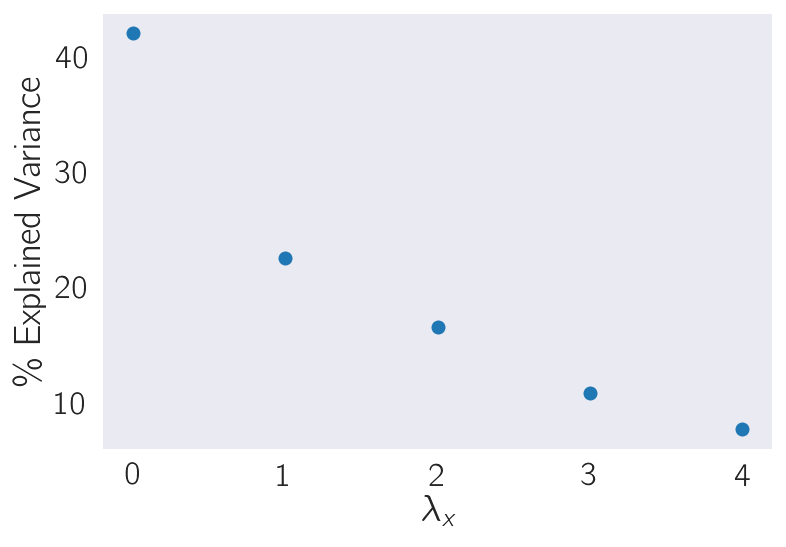

In [6]:
# generate a plot of Explained variance versus Eigenvalue index
# note indexing starts at 0.
plt.plot(pca.explained_variance_ratio_*100, 'o')
_ = plt.xlabel(r'$\lambda_x$')
_ = plt.ylabel(r'\% Explained Variance')

The plot shows that the 0 and 1 eigenvalues explain 60% of the variance, eigenvalues 2 and 3 explain about 30% of the variance and the 4th eigenvalue explains 10% of the variance. So the picture we looked at before is a good representation for about half of the data, and much more may be going on than is shown.

# *dpy-22* alleles' shared transcriptomic phenotypes

In [7]:
def odr(txtome, strain_x, strain_y):
    """
    Calculate a regression line of the STP between strain_x and strain_y.
    
    Params:
    txtome - a txtome object initialized with a dataframe
    strain_x, strain_y - str, strains for which to find STP and
                            perform regression.
    
    Output:
    res - An ODR object containing a res.beta list with the parameters of the
            regression (res.beta[0] is the slope)
    """
    # find the STP between strain x and y:
    tmp = txtome.select_from_overlap([strain_x, strain_y])

    # extract the target_ids by strain:
    x = tmp[tmp.strain == strain_x]
    y = tmp[tmp.strain == strain_y]
    
    # perform an odr regression:
    res = epi.perform_odr(x.b.values, y.b.values,
                          x.se_b.values, y.se_b.values,
                          beta0=[0.5])
    return res

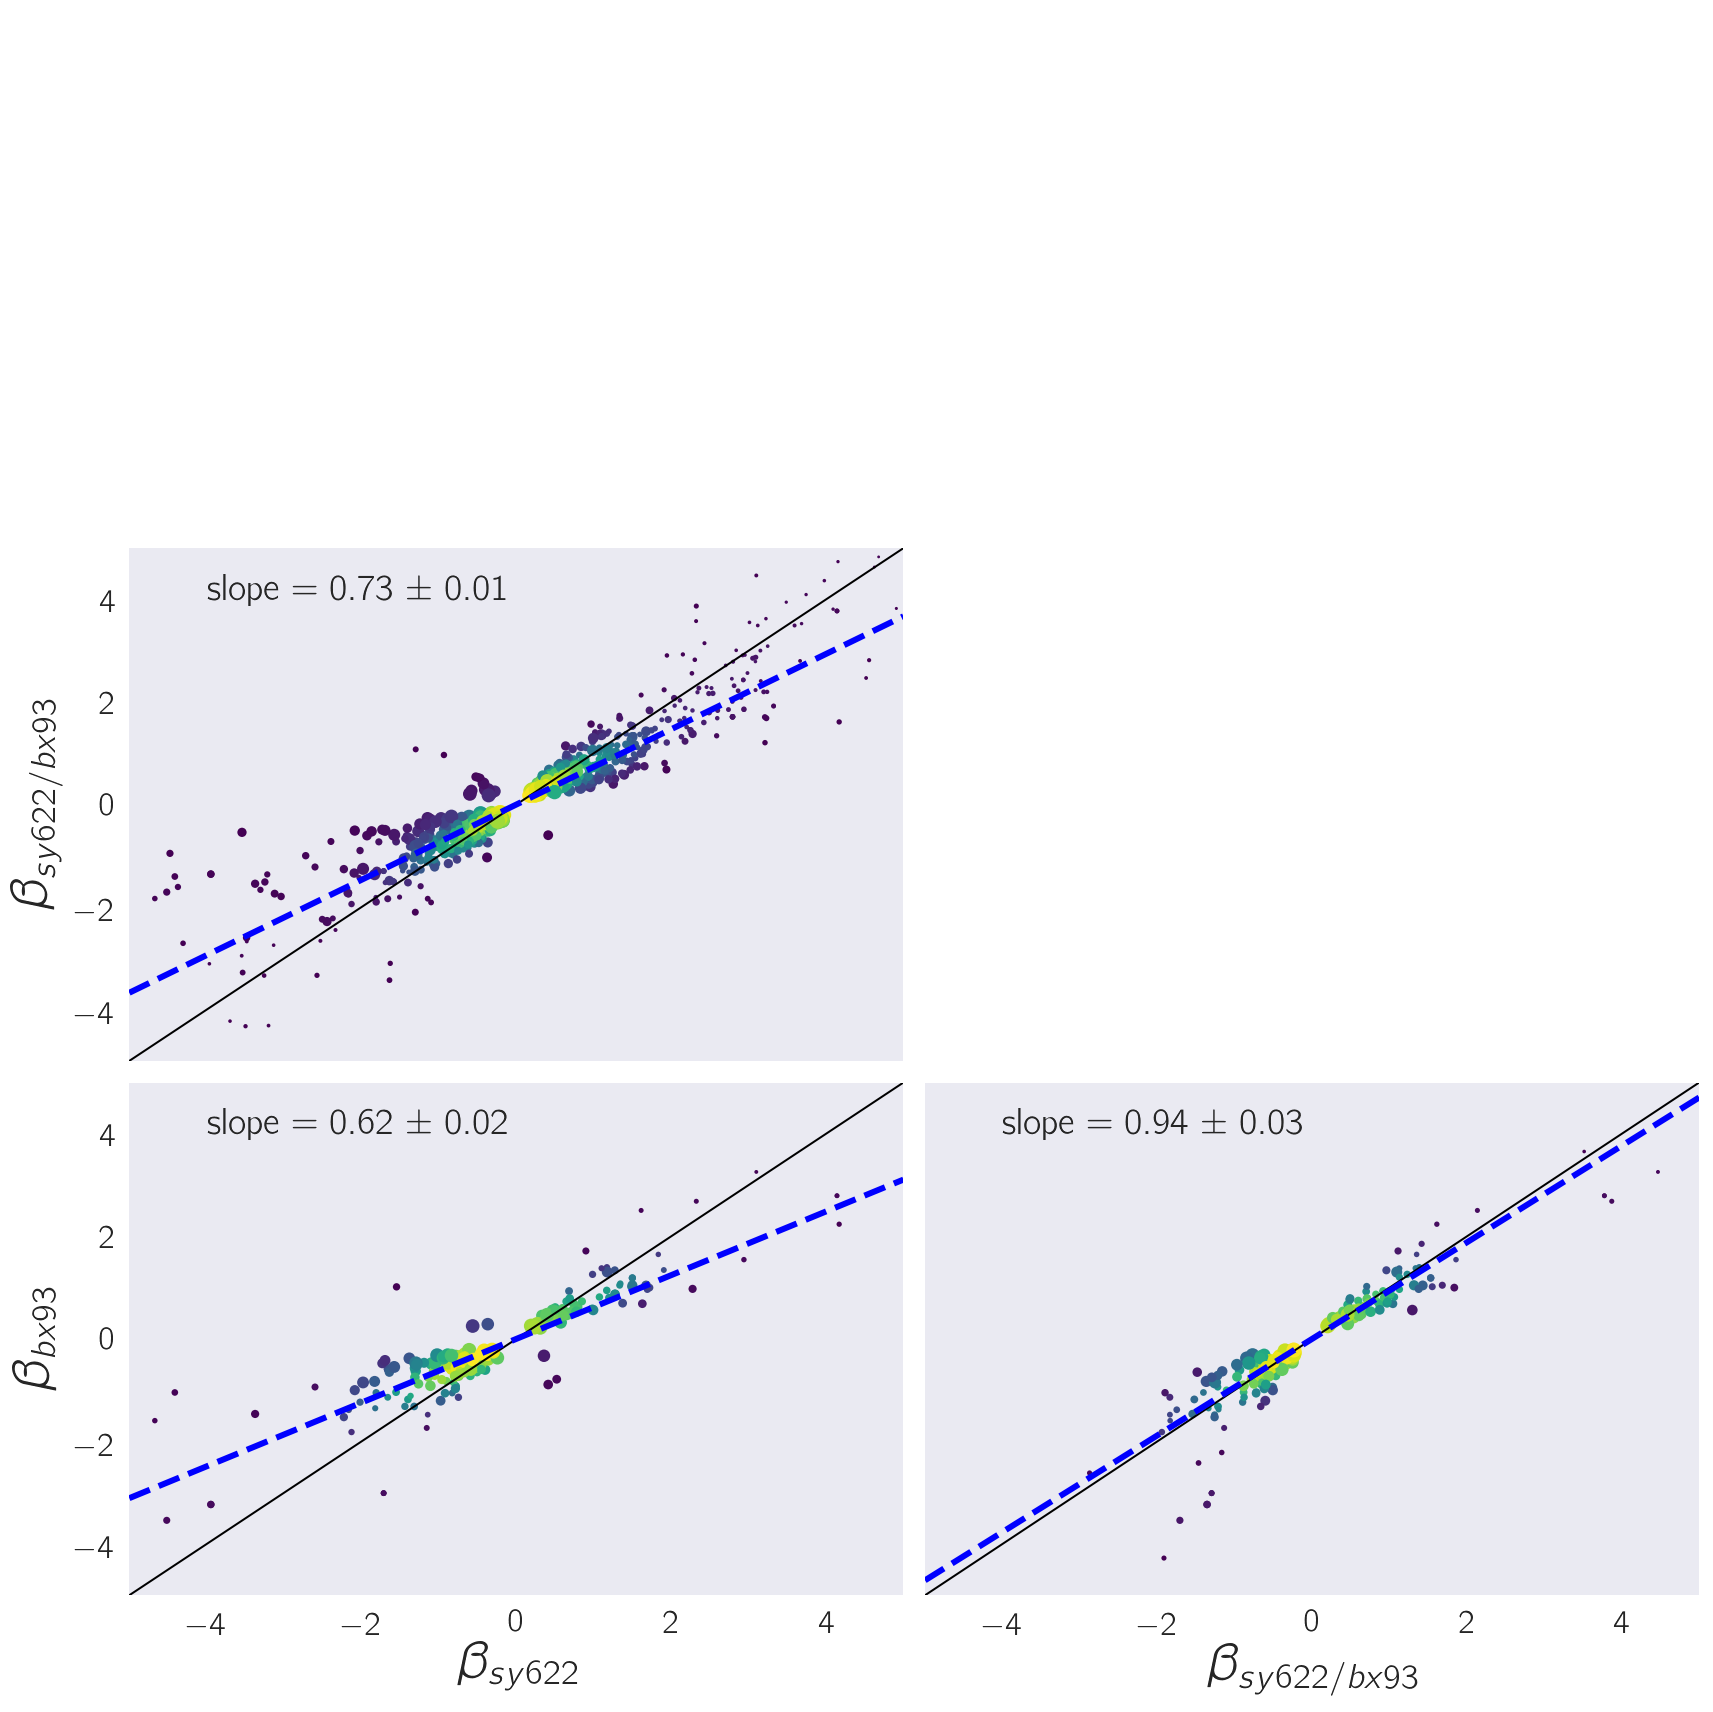

In [8]:
# condition to select the dpy-22 samples:
cond = quant.df.fancy.str.contains('dpy-22')
subset = np.sort(quant.df[cond].strain.unique())

# count the genotypes in this:
n = len(subset)

fig, ax = plt.subplots(nrows=n, ncols=n-1, figsize=(12, 12),
                       sharex=True, sharey=True)

for i, strain in enumerate(subset):
    for j, strain2 in enumerate(subset):
        # turn off upper triangle and diagonal axes
        if i >= j:
            if i < n-1:
                ax[j, i].axis('off')
            continue

        # skip identity
        if strain == strain2:
            continue

        # plot the shared transcriptomic phenotype
        quant.plot_STP(strain, strain2, label=False, ax=ax[j, i], 
                       density=True, cmap='viridis')

        # also plot the line y=x
        x = np.linspace(-5, 5)
        ax[j, i].plot(x, x, color='k', lw=1)
        
        # perform regression
        res = odr(quant, strain, strain2)
        
        # plot the regression and annotate to the corner
        ax[j, i].plot(x, res.beta[0]*x, color='blue', ls='--', lw=3)
        m = 'slope = {0:.2g} $\pm$ {1:.1g}'.format(res.beta[0], 
                                                   res.sd_beta[0])
        ax[j, i].annotate(m, (-4, 4), fontsize=18)

    # find and typeset labels:
    if 'PS4087' in strain:
        genotype = r'$\beta_{sy622}$'
    elif 'PS4187' in strain:
        genotype = r'$\beta_{bx93}$'
    else:
        genotype = r'$\beta_{sy622/bx93}$'
    # label
    if i < n-1:
        ax[n-1, i].set_xlabel(genotype, fontsize=25)
    if i < n:
        ax[i, 0].set_ylabel(genotype, fontsize=25)

plt.xlim(-5, 5) 
plt.ylim(-5, 5)
plt.tight_layout()

plt.savefig('../output/dpy22_STPs.svg', bbox_inches='tight')